In [ ]:
import cv2
import os
import numpy as np
from math import *
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from lesson_functions import *
np.random.seed(0xdeadbeef)

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

In [2]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 0 # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [ ]:
t=time.time()
cars = glob.iglob('data/vehicles/**/*.png')
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcars = glob.iglob('data/non-vehicles/**/*.png')
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

In [ ]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=np.random.randint(1000))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0xdeadbeef)

In [ ]:
# clf = Pipeline([('scaling', StandardScaler()),
#                  ('feature_selection', SelectFromModel(ExtraTreesClassifier())),
#                 ('classification', LinearSVC(loss='hinge')),
#                ])

# Check the training time for the SVC
t=time.time()
clf.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

In [ ]:
print('Test Accuracy of classifier = ', round(clf.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My classifier predicts: ', clf.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels')

In [ ]:
from shutil import copyfile

def make_hardneg(out_path, neg=True):
    y_pred = clf.predict(X)

    if neg:
        notcars = glob.glob('data/non-vehicles/**/*.png')
    else:
        cars = glob.glob('data/vehicles/**/*.png')
    offset = len(car_features)

    # Wrong indices
    wrong = np.nonzero(y_pred != y)[0]
    for w in wrong:
        # False positives
        if neg and y_pred[w] == 1 and y[w] == 0:
            fname = notcars[w - offset]
            copyfile(fname, out_path+'/hardneg_'+str(w - offset)+'.png')
        elif not neg and y_pred[w] == 0 and y[w] == 1:
            fname = cars[w]
            copyfile(fname, out_path+'/hardpos_'+str(w)+'.png')

# make_hardneg('data/hardpos/', False)
from sklearn.metrics import confusion_matrix
y_pred = clf.predict(X)
conf = confusion_matrix(y, y_pred)
print(conf)

In [ ]:
from sklearn.externals import joblib
config = dict(color_space=color_space, 
            spatial_size=spatial_size, hist_bins=hist_bins, 
            orient=orient, pix_per_cell=pix_per_cell, 
            cell_per_block=cell_per_block, 
            hog_channel=hog_channel, spatial_feat=spatial_feat, 
            hist_feat=hist_feat, hog_feat=hog_feat)
# joblib.dump({'model':svc, 'config':config, 'scaler':X_scaler}, 'models/model_9919.pkl')
# joblib.dump({'model':svc, 'config':config}, 'models/clf_9805.pkl')
joblib.dump({'model':clf, 'config':config}, 'models/clf_9885_newhog.pkl')

In [31]:
# data = joblib.load('models/clf_9892_ycbcr.pkl')
data = joblib.load('models/clf_9885_newhog.pkl')
# svc = data['model']
clf = data['model']
config = data['config']

color_space = config['color_space']
spatial_size = config['spatial_size']
hist_bins = config['hist_bins']
orient = config['orient']
pix_per_cell = config['pix_per_cell']
cell_per_block = config['cell_per_block']
hog_channel = config['hog_channel']
spatial_feat = config['spatial_feat']
hist_feat = config['hist_feat']
hog_feat = config['hog_feat']
print(config)

{'cell_per_block': 2, 'pix_per_cell': 8, 'spatial_feat': True, 'spatial_size': (16, 16), 'hog_feat': True, 'orient': 9, 'hist_bins': 16, 'color_space': 'YUV', 'hist_feat': True, 'hog_channel': 0}


In [32]:
pyramid = [((64, 64),  [400, 500]),
           ((96, 96),  [400, 500]),
           ((128, 128),[450, 578]),
           ((192, 192),[400, None]),
#             ((256, 256),[450, None])
      ]
image_size = (720, 1280)
windows = create_windows(pyramid, image_size)

In [41]:
def search_windows(img, windows, clf, color_space='RGB',
                    spatial_size=None, hist_bins=32,
                    hist_range=(0, 256), orient=9,
                    pix_per_cell=8, cell_per_block=2,
                    hog_channel=0, spatial_feat=True,
                    hist_feat=True, hog_feat=True):

    if spatial_size is None:
        spatial_size = (32, 32)

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    all_features = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = np.array(features).reshape(1, -1)

        #6) Predict using your classifier
        dec = clf.decision_function(test_features)
        prediction = int(dec > 0.5)

        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [144]:
def create_windows(pyramid, image_size):
    output = []
    for w_size, y_lims in pyramid:
        windows = slide_window(image_size, x_start_stop=[None, None], y_start_stop=y_lims, 
                        xy_window=w_size, xy_overlap=(0.5, 0.5))
        output.extend(windows)
    return output

def multiscale_detect(image, clf, config, windows, verbose=False):
    
    color_space = config['color_space']
    spatial_size = config['spatial_size']
    hist_bins = config['hist_bins']
    orient = config['orient']
    pix_per_cell = config['pix_per_cell']
    cell_per_block = config['cell_per_block']
    hog_channel = config['hog_channel']
    spatial_feat = config['spatial_feat']
    hist_feat = config['hist_feat']
    hog_feat = config['hog_feat']
    
    candidates = search_windows(image, windows, clf, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    return candidates

def update_heatmap(candidates, image_shape, heatmap = None):
    if heatmap is None:
        heatmap = np.zeros((image_shape[0], image_shape[1]), np.uint8)

    for pt1, pt2 in candidates:
        x1, y1 = pt1
        x2, y2 = pt2
        xv, yv = np.meshgrid(range(x1, x2), range(y1, y2))

        heatmap[yv, xv] += 1

#     cv2.GaussianBlur(heatmap, (31,31), 0, dst=heatmap)
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def find_vehicles(heatmap):
    # Detect clusters
    labels = label(heatmap)

    _, contours, _ = cv2.findContours(heatmap, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    bboxes = [cv2.boundingRect(pts) for pts in contours]
    return bboxes

In [142]:
image = mpimg.imread('test_images/test6.jpg')

uint8
255
Detected 3 vehicles in 0.28 seconds


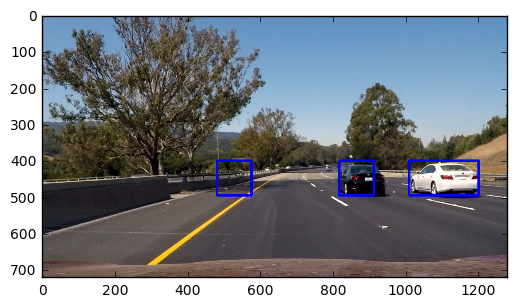

In [143]:
t = time.time()
from sklearn import metrics

candidates = multiscale_detect(image, clf, config, windows)

heatmap = update_heatmap(candidates, image.shape)
plt.imshow(heatmap)
labels = label(heatmap)
im2 = draw_labeled_bboxes(np.copy(image), labels)
t2 = time.time() - t 
print('Detected %d vehicles in %.2f seconds' % (len(bboxes), t2))

plt.imshow(im2)

plt.show()

In [147]:
import collections
def process_image(image, params):
    config, clf, windows = params['clf_config'], params['clf'], params['windows']

    if params['cache_enabled']:
        cache = process_image.cache
        if cache['heatmaps'] is None:
            cache['heatmaps'] = collections.deque(maxlen=params['heatmap_cache_length'])
        frame_ctr = cache['frame_ctr']
        
        cache['frame_ctr'] += 1
        
    candidates = multiscale_detect(image, clf, config, windows)
    current_heatmap = update_heatmap(candidates, image.shape)
    if params['cache_enabled']:
        cache['heatmaps'].append(current_heatmap)

    thresh_heatmap = sum(cache['heatmaps'])
    thresh_heatmap[thresh_heatmap < params['heatmap_threshold']] = 0
    labels = label(thresh_heatmap)
    im2 = draw_labeled_bboxes(np.copy(image), labels)
    
    return im2

def clear_cache():
    process_image.cache = {
        'last_heatmap': None,
        'heatmaps': None,
        'frame_ctr': 0
    }

CPU times: user 202 ms, sys: 4.02 ms, total: 206 ms
Wall time: 203 ms


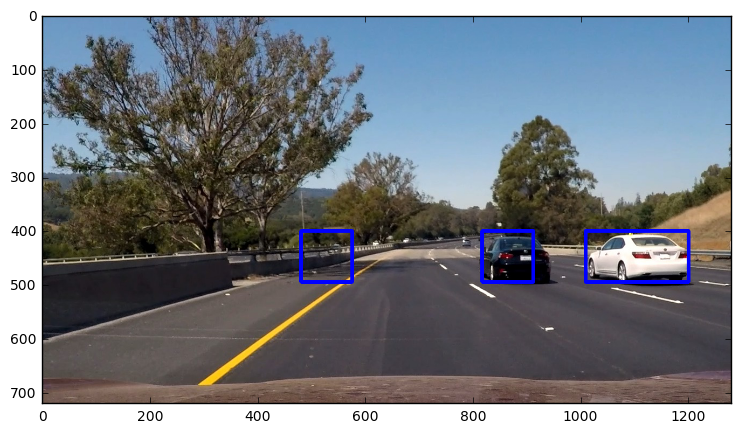

In [148]:
clear_cache()
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 10
params['heatmap_threshold'] = 2

for i in range(11):
    im2 = process_image(image, params)
%time process_image(image, params)
plt.figure(figsize=(10,5))
plt.imshow(im2)
plt.show()
# test_images = glob.glob('test_images/*.jpg')
# for fname in test_images:
#     im = mpimg.imread(fname)
#     im2 = process_image(im, params)
#     mpimg.imsave('output_images/'+os.path.basename(fname), im2)

In [149]:
params = {}
params['clf_config'] = config
params['clf'] = clf
params['windows'] = windows
params['cache_enabled'] = True
params['heatmap_cache_length'] = 6
params['heatmap_threshold'] = 2

vid_output = 'project_short_out.mp4'
clip = VideoFileClip('project_short.mp4')

In [150]:
vid_clip = clip.fl_image(lambda x: process_image(x, params))
%time vid_clip.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video project_short_out.mp4
[MoviePy] Writing video project_short_out.mp4


100%|█████████▉| 200/201 [01:04<00:00,  3.41it/s]     | 1/201 [00:00<00:48,  4.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_short_out.mp4 

CPU times: user 56.1 s, sys: 2.83 s, total: 58.9 s
Wall time: 1min 7s


In [151]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))